In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scienceplots
import seaborn as sns
import matplotlib.animation as animation
from scipy.fft import rfft, rfftfreq
from scipy import signal

N_voltages      = 1000
max_time        = 2e-4
sample_rate     = (N_voltages-1)/max_time
time_steps      = np.linspace(0,max_time,N_voltages)
time_steps      = time_steps[1:]
blue_color      = '#4477AA'
red_color       = '#EE6677'

cmeter      = 1/2.54
single_col  = 8.6


# Main

In [114]:
dfs     = []
n_stat  = 0
for i in range(0,10):

    for j in range(10):

        df_tmp          = pd.read_csv(f"data/Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
        dfs.append(df_tmp)
        n_stat += 1
df          = sum(dfs)/len(dfs)
test        = pd.DataFrame(np.std(np.stack(dfs), axis=0), columns=df.columns)
df['Error'] = test['Current']
df          = df.drop(columns=['Eq_Jumps'])
df['Error'] = df['Error']/np.sqrt(n_stat)

df

,E0,E1,E2,E3,E4,E5,E6,E7,G,Jumps,Current,Error
0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90877.14,1.722096,0.225149
1,0.049604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93647.61,1.597580,0.207416
2,0.048423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96172.02,1.447674,0.173568
3,0.046475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98361.48,0.723924,0.142513
4,0.043791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100288.53,0.499298,0.111643
...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.040414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,753225.94,0.374574,0.095900
495,0.043791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,755175.64,0.524400,0.107661
496,0.046475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,757368.88,0.649142,0.135025
497,0.048423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,759919.70,1.347838,0.163375


## I-O dependency

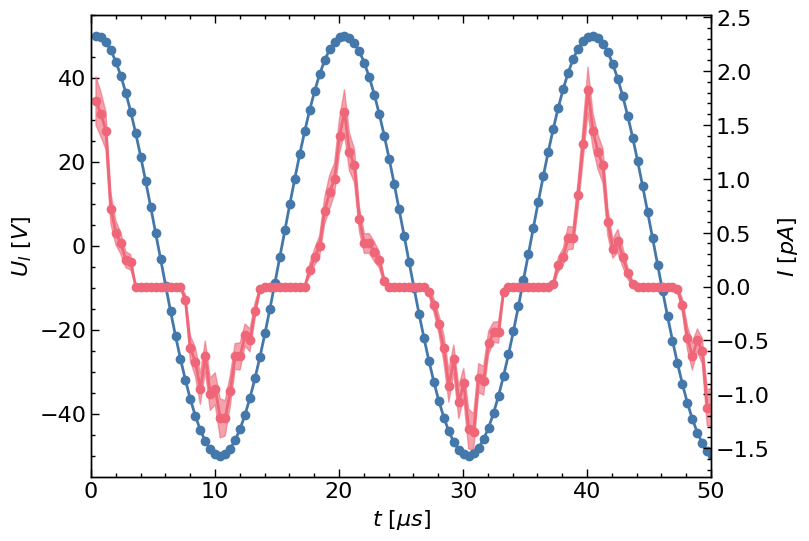

In [115]:
with plt.style.context(['science', 'bright', 'notebook']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    ax1.plot(time_steps*10**6, df['E0']*1000, '-o', color=blue_color)
    ax2.plot(time_steps*10**6, df['Current'], '-o', color=red_color)
    ax2.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=red_color, alpha=.6)
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('$U_I$ [$V$]')
    ax2.set_ylabel('$I$ [$pA$]')
    ax1.set_xlim(0,50)
    ax1.set_ylim(-55,55)
    # ax2.set_ylim(-55,55)
    
plt.show()

## Frequency

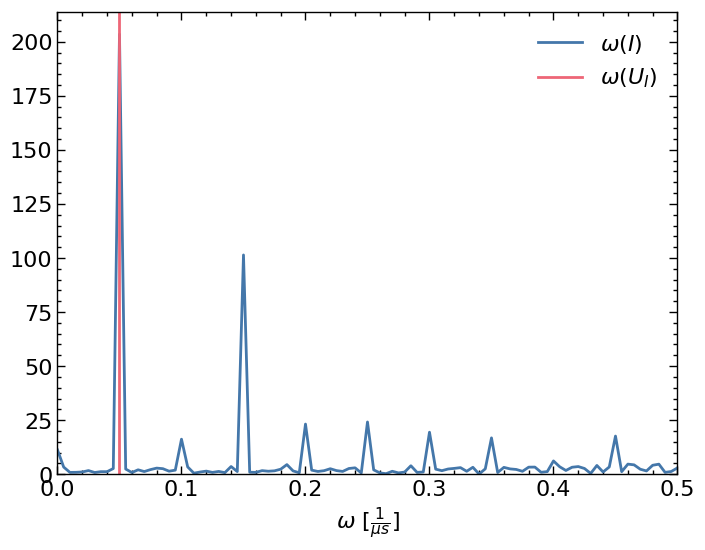

In [116]:
signal  = np.int16((df['Current'].values / df['Current'].values.max()) * 32767)
signal  = df['Current'].values
input_f = (0.5e5)/10**6

with plt.style.context(['science', 'bright', 'notebook']):

    yf = rfft(signal)
    xf = rfftfreq(N_voltages-1, 1 / sample_rate)

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(xf/10**6, np.abs(yf), label="$\omega(I)$")
    ax.axvline(input_f, color=red_color, label="$\omega(U_I)$")
    ax.set_xlabel("$\omega$ [$\\frac{1}{\mu s}$]")
    ax.set_ylim(0)
    ax.set_xlim(0,0.5)
    ax.legend()

plt.show()

## combined

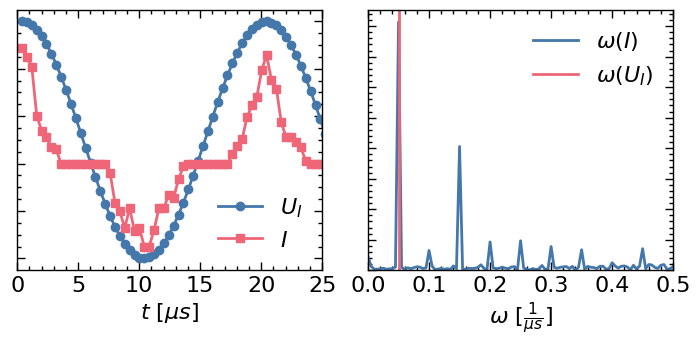

In [117]:
def min_max(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

signal  = np.int16((df['Current'].values / df['Current'].values.max()) * 32767)
signal  = df['Current'].values
input_f = (0.5e5)/10**6

with plt.style.context(['science', 'bright','notebook']):

    fig = plt.figure()
    fig.set_figwidth(2.5*single_col*cmeter)
    fig.set_figheight(single_col*cmeter/1)

    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(time_steps*10**6, min_max(df['E0'].values), '-o', color=blue_color, label='$U_I$')
    ax1.plot(time_steps*10**6, min_max(df['Current'].values), '-s', color=red_color, label='$I$')
    # ax1.fill_between(time_steps*10**6, min_max(df['Current']-df['Error']), min_max(df['Current']+df['Error']), color=red_color, alpha=.6)
    ax1.set_xlabel('$t$ [$\mu s$]')
    # ax1.set_ylabel('Signal')
    ax1.set_xlim(0,25)
    ax1.set_yticklabels("")
    ax1.legend(loc='lower right')

    yf = rfft(signal)
    xf = rfftfreq(N_voltages-1, 1 / sample_rate)

    ax  = fig.add_subplot(1,2,2)
    ax.plot(xf/10**6, np.abs(yf), label="$\omega(I)$")
    ax.axvline(input_f, color=red_color, label="$\omega(U_I)$")
    ax.set_xlabel("$\omega$ [$\\frac{1}{\mu s}$]")
    ax.set_ylim(0)
    ax.set_xlim(0,0.5)
    ax.legend()
    ax.set_yticklabels("")
    plt.subplots_adjust(wspace=0.15)

    fig.savefig(f"plots/1_In_1_Out_time_dep.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/1_In_1_Out_time_dep.pdf", bbox_inches='tight', transparent=False)

plt.show()

### Noise

In [188]:
noise_data  = {}
n           = 0

for i in range(0,10):

    for j in range(10):

        df_tmp          = pd.read_csv(f"data/noise/Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
        df_tmp          = df_tmp.drop(columns=['Eq_Jumps', 'Error'])
        noise_data[n]   = df_tmp
        n               += 1

noise_data[0]

,E0,E1,E2,E3,E4,E5,E6,E7,G,Jumps,Current
0,-0.773568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119632.0,-2042.967723
1,-0.835035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,234372.0,-2257.774243
2,-0.889063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,357305.0,-2462.599733
3,-0.881597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478382.0,-2407.607762
4,-0.909792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,604315.0,-2637.375413
...,...,...,...,...,...,...,...,...,...,...,...
994,-0.442679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48119856.0,-729.272897
995,-0.392303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48164897.0,-679.325928
996,-0.303953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48196718.0,-324.678962
997,-0.247167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48220663.0,-189.810803


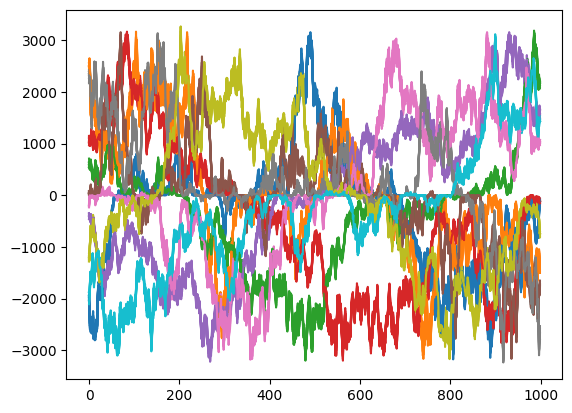

In [189]:
fig = plt.figure()
ax  = fig.add_subplot()

for key,df in noise_data.items():

    ax = df['Current'].plot(ax=ax)

plt.show()

In [ ]:
def memory_cap(x, y):

    x_norm  = x - np.mean(x)
    y_norm  = y - np.mean(y)
    lags    = np.arange(0, len(test_x))
    
    np.roll(x, -lag)-np.mean(x)
    

In [250]:
ccorr_list = []

for key, df in noise_data.items():
    
    test_x  = df['E0'].values
    test_y  = df['Current'].values
    lags    = np.arange(0, len(test_x))
    x       = test_x - np.mean(test_x)
    y       = test_y - np.mean(test_y)
    ccorr   = [(np.correlate(test_x, np.roll(test_y, -lag)) / (np.linalg.norm(test_x) * np.linalg.norm(test_y)))[0] for lag in lags]
    
    ccorr_list.append(ccorr)

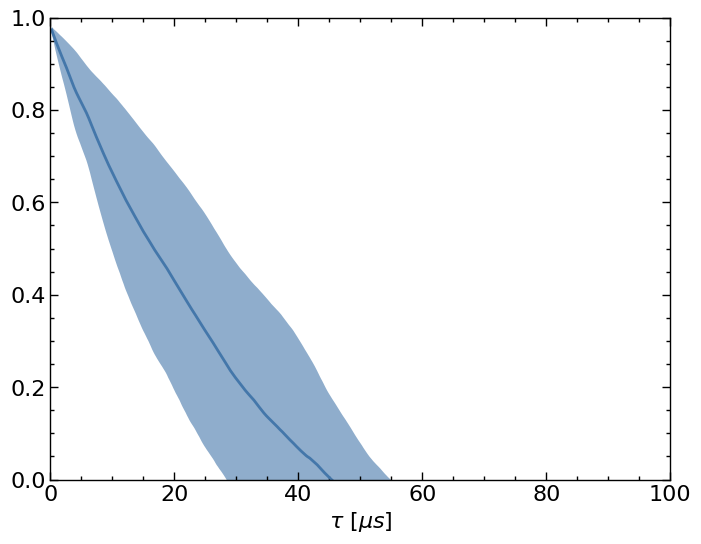

In [282]:
means   = np.mean(np.array(ccorr_list).T,axis=1)
stds    = np.std(np.array(ccorr_list).T,axis=1)

with plt.style.context(['science', 'bright','notebook']):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time_steps*10**6, means, '-')
    ax.fill_between(time_steps*10**6, means-stds, means+stds, alpha=0.6)
    # ax.plot(time_steps*10**6, np.mean(np.array(ccorr_list).T,axis=1))
    ax.set_xlabel("$\\tau$ [$\mu s$]")
    ax.set_xlim(0,100)
    ax.set_ylim(0,1)

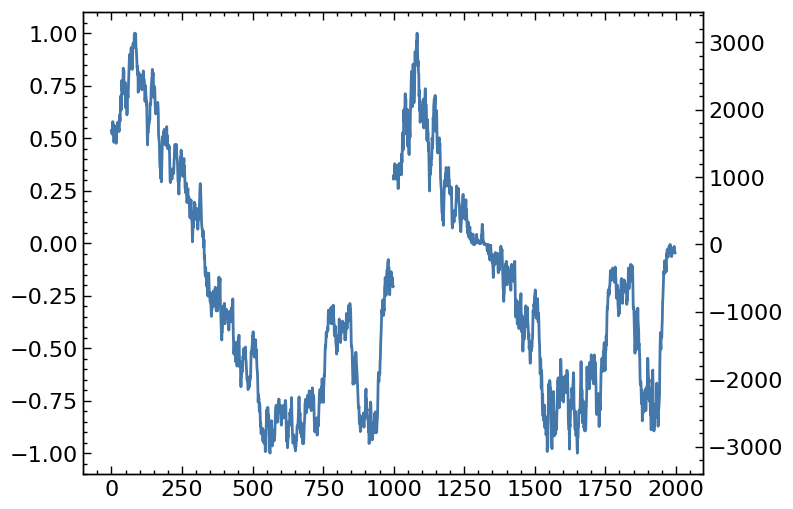

In [201]:
with plt.style.context(['science', 'bright','notebook']):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(np.arange(0,len(test_x)), test_x)
    ax2 = ax.twinx()
    ax2.plot(np.arange(len(test_x),len(test_x)*2), test_y)

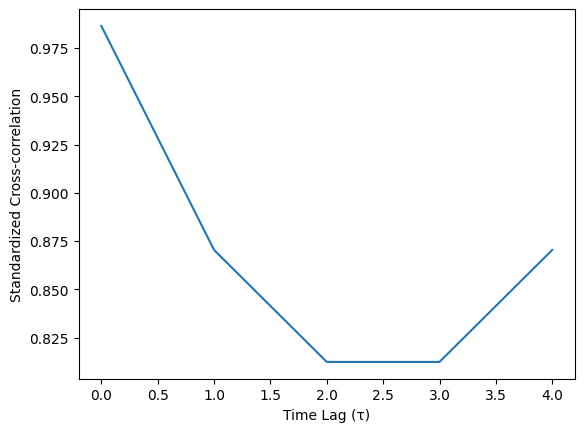

In [225]:
# Sample time series data for x and y
x = np.array([1, 2, 3, 4, 5])
y = np.array([3, 4, 5, 6, 7])

# Calculate the cross-correlation using the normalized cross-correlation formula
cross_corr = [np.correlate(x, np.roll(y, -lag)) / (np.linalg.norm(x) * np.linalg.norm(y)) for lag in range(len(x))]

# Create the lag values
lags = range(len(x))

# Plot the standardized cross-correlation as a function of τ
plt.plot(lags, cross_corr)
plt.xlabel('Time Lag (τ)')
plt.ylabel('Standardized Cross-correlation')
plt.show()

In [108]:
blue_color          = '#4477AA'
red_color           = '#EE6677'

with plt.style.context(["science","nature","bright"]):
    
    fig, ax1    = plt.subplots(dpi=200)
    ax2         = ax1.twinx()

    ax1.errorbar(x=time_steps[:-1]*1000 ,y=df['O'], yerr=df['sO'], c=blue_color)
    ax2.plot(time_steps[:-1]*1000, df['I']*1000, c=red_color)
    ax1.set_xlabel("Time [ms]")
    ax1.set_ylabel("Output [pA]")
    ax2.set_ylabel("Input [mV]")

    ax1.legend(['Output'], loc='lower left')
    ax2.legend(['Input'], loc='lower right')

    ax1.set_ylim(-1500,1500)
    ax2.set_ylim(-50,50)

plt.show()

KeyError: 'O'

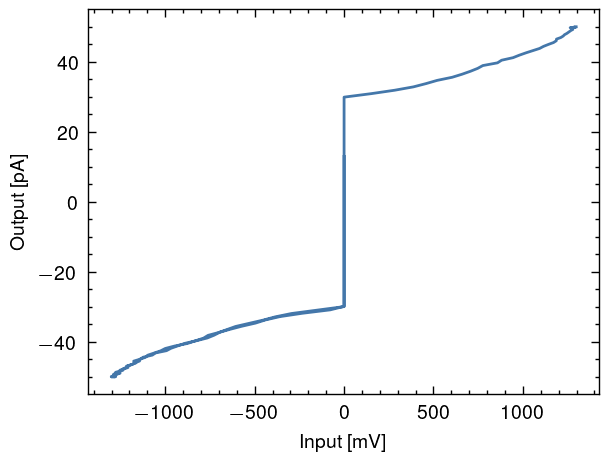

In [62]:
with plt.style.context(["science","nature","bright"]):
    
    fig, ax1    = plt.subplots(dpi=200)
    df          = dic[0.5]

    ax1.plot(df['O'], df['I']*1000)
    ax1.set_xlabel("Input [mV]")
    ax1.set_ylabel("Output [pA]")
    plt.show()

# States

In [63]:
f_mult          = 2
states          = pd.read_csv(f"time_mean_state_Nx=2_Ny=2_Nz=1_Ne=2_6_f{f_mult}.csv")
states.columns  = [i for i in range(2,6)]
states[0]       = 100
states[1]       = 100
states          = states[[0,1,2,3,4,5]]
edges   = pd.read_csv(f"time_net_currents_Nx=2_Ny=2_Nz=1_Ne=2_0_f{f_mult}.csv").columns
pos     = {0:(0,0),
           1:(1.5,1.5),
           2:(0.5,0.5),
           3:(1,0.5),
           4:(0.5,1),
           5:(1,1),
           }

G       = nx.Graph()
G.add_edges_from([eval(i) for i in edges])

In [64]:
fig     = plt.figure()
ax_c    = []

for row in range(len(states)):

    node_sizes  = {j:np.abs(states.iloc[row,j]) for j in range(6)}
    size        = np.array([node_sizes[0],node_sizes[2],node_sizes[1],node_sizes[5],node_sizes[3],node_sizes[4]])

    ax = fig.add_subplot()
    nx.draw_networkx(G, pos=pos, node_size=200*np.log(size), ax=ax)
    plt.axis('off')
    
    ax_c.append([ax])

ani = animation.ArtistAnimation(fig=fig, artists=ax_c, interval=50, repeat_delay=500)

/home/jonas/.local/lib/python3.10/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [65]:
ani.save("test.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.
/home/jonas/.local/lib/python3.10/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
